## Exploratory Data Analysis - Pt 2
### Data Visualization 

In [18]:
#import libraries and read the csv file
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fire_df = pd.read_csv("data/fire.csv")

In [19]:
#repeat cleaning steps from part 1
fire_df['CREATE_TIME_INCIDENT'] = pd.to_datetime(fire_df['CREATE_TIME_INCIDENT'], format='%m/%d/%Y %I:%M:%S %p')
fire_df['ARRIVAL_TIME_PRIMARY_UNIT'] = pd.to_datetime(fire_df['ARRIVAL_TIME_PRIMARY_UNIT'], format='%m/%d/%Y %I:%M:%S %p')
fire_df['CLOSED_TIME_INCIDENT'] = pd.to_datetime(fire_df['CLOSED_TIME_INCIDENT'], format='%m/%d/%Y %I:%M:%S %p')
fire_df['DISPATCH_TIME_PRIMARY_UNIT'] = pd.to_datetime(fire_df['DISPATCH_TIME_PRIMARY_UNIT'], format='%m/%d/%Y %I:%M:%S %p')
fire_df.dtypes

ADDRESS_X                             object
LATITUDE_X                           float64
LONGITUDE_X                          float64
AGENCY                                object
CREATE_TIME_INCIDENT          datetime64[ns]
DISPOSITION_TEXT                      object
EVENT_NUMBER                          object
INCIDENT_TYPE_ID                      object
INCIDENT_TYPE_DESC                    object
NEIGHBORHOOD                          object
ARRIVAL_TIME_PRIMARY_UNIT     datetime64[ns]
BEAT                                  object
CLOSED_TIME_INCIDENT          datetime64[ns]
DISPATCH_TIME_PRIMARY_UNIT    datetime64[ns]
CFD_INCIDENT_TYPE                     object
CFD_INCIDENT_TYPE_GROUP               object
dtype: object

In [20]:
#derive variables
import datetime

TTA = pd.to_timedelta(fire_df['ARRIVAL_TIME_PRIMARY_UNIT'] - fire_df['DISPATCH_TIME_PRIMARY_UNIT'])
TTC = pd.to_timedelta(fire_df['CLOSED_TIME_INCIDENT'] - fire_df['CREATE_TIME_INCIDENT'])

In [21]:
## add the derived variables to the main dataframe
TTA_int = TTA / np.timedelta64(1, 'm')
TTA_int
fire_df['TTA'] = TTA_int

TTC_int = TTC / np.timedelta64(1, 'm')
TTC_int
fire_df['TTC'] = TTC_int

In [5]:
#remove values with negative times
print(len(fire_df))

clean_df = fire_df[fire_df['TTA'] > 0]
clean_df = clean_df[clean_df['TTC'] > 0]

print(len(clean_df))

256308
211773


In [6]:
clean_df = clean_df[clean_df['TTA'] < clean_df['TTC']]

In [7]:
#remove outliers
clean_df = clean_df[clean_df['TTA'] < 500]
clean_df = clean_df[clean_df['TTC'] < 1000]
len(clean_df)

211472

In [226]:
#With cleaning finished, we can take a subset
near_uc = fire_df[fire_df['NEIGHBORHOOD'].isin(['CLIFTON','CORRYVILLE','CUF'])]
print(len(near_uc))

#Take a subset using .query
campus_neighborhoods = ['CLIFTON','CORRYVILLE','CUF']
off_campus = fire_df.query('NEIGHBORHOOD not in @campus_neighborhoods')
print(len(off_campus.index))

16083
240225


## Pandas GroupBy Objects
* We may want to examine the data by neighborhood, incident type, disposition, etc.. 
* GroupBy Objects have most properties of a DataFrame, but they enable easy calculations on data by the specified group.

## Big Picture Graphs
* Start with overall trends

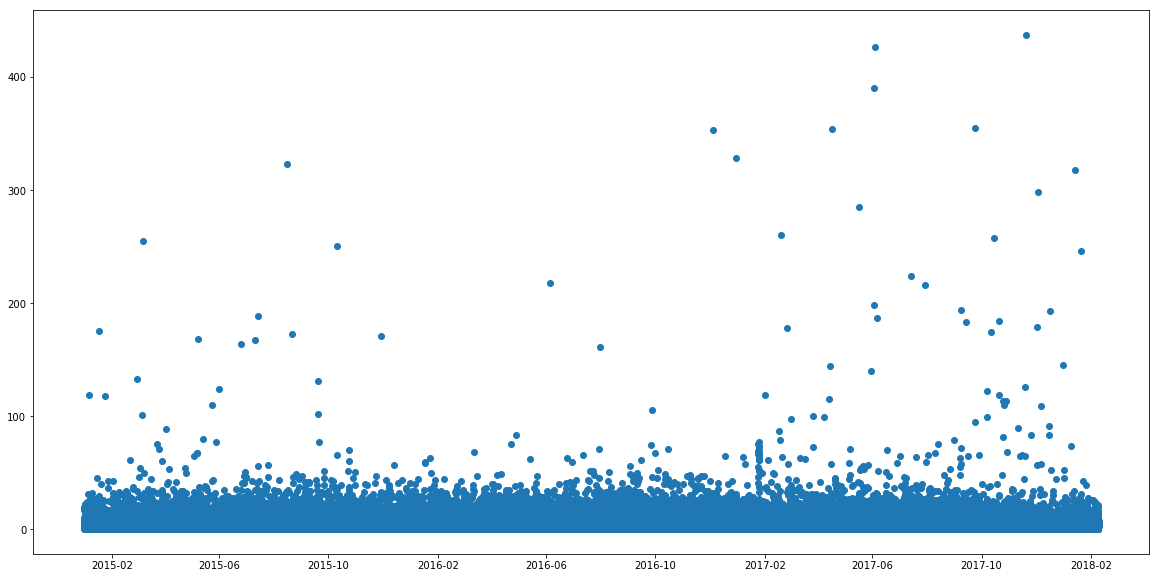

In [69]:
by_date = clean_df.groupby(pd.DatetimeIndex(clean_df['CREATE_TIME_INCIDENT']).normalize())
plt.figure(figsize=(20,10))
plt.plot_date(clean_df['CREATE_TIME_INCIDENT'], clean_df['TTA'])

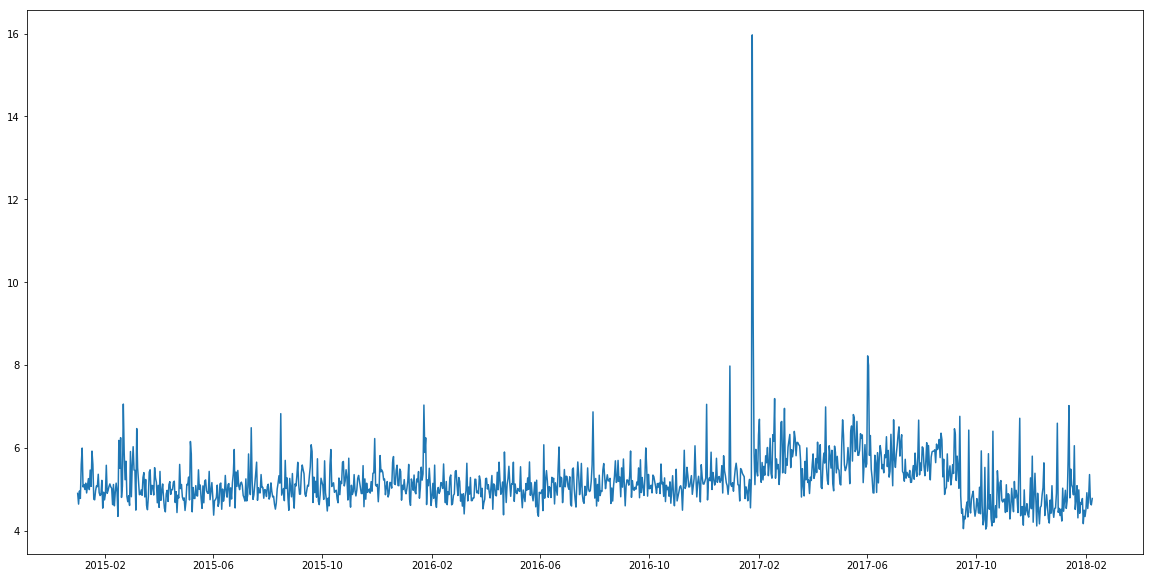

In [92]:
# The above is not a great way to gain insight from our data. Let's try a line graph
mean_TTA = by_date['TTA'].mean()
mean_TTA
plt.figure(figsize=(20,10))
plt.plot(mean_TTA)

In [95]:
mean_TTA.describe()

count    1135.000000
mean        5.196810
std         0.627248
min         4.034414
25%         4.847181
50%         5.106499
75%         5.442784
max        15.970098
Name: TTA, dtype: float64

In [134]:
#What if we want to examine the outlier?
outlier = mean_TTA[mean_TTA > 8]
outlier

CREATE_TIME_INCIDENT
2017-01-24    15.970098
2017-01-25     9.150667
2017-06-02     8.217838
Name: TTA, dtype: float64

In [104]:
#patterns may emerge by grouping the data. What if we look at the mean by month?
by_month = clean_df.groupby(clean_df['CREATE_TIME_INCIDENT'].dt.to_period('M'))
mean_monthly_TTA = by_month['TTA'].mean()
mean_monthly_TTA

CREATE_TIME_INCIDENT
2015-01    5.069071
2015-02    5.207248
2015-03    5.177375
2015-04    4.914848
2015-05    5.014391
2015-06    4.970128
2015-07    5.075413
2015-08    5.003573
2015-09    5.194604
2015-10    5.112156
2015-11    5.079432
2015-12    5.204734
2016-01    5.216720
2016-02    5.003036
2016-03    4.925489
2016-04    5.088484
2016-05    4.968926
2016-06    5.123464
2016-07    5.141361
2016-08    5.152583
2016-09    5.187561
2016-10    5.054812
2016-11    5.139256
2016-12    5.376587
2017-01    5.605390
2017-02    5.747062
2017-03    5.704721
2017-04    5.624558
2017-05    5.918219
2017-06    5.769862
2017-07    5.664445
2017-08    5.728679
2017-09    5.049877
2017-10    4.745813
2017-11    4.748137
2017-12    4.755723
2018-01    4.817929
2018-02    4.774648
Freq: M, Name: TTA, dtype: float64

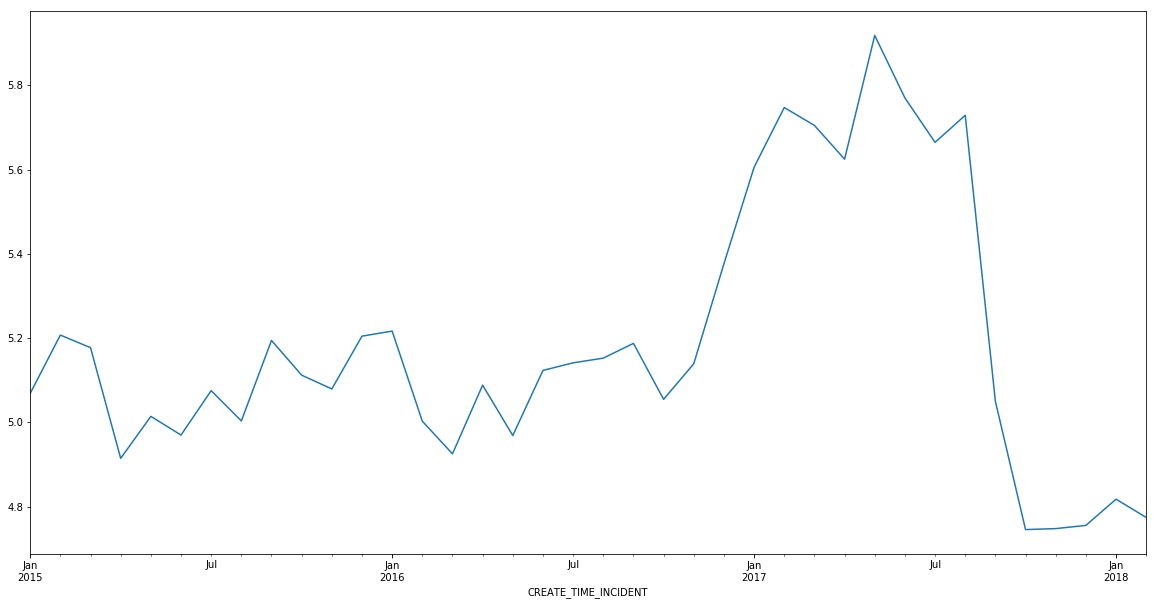

In [123]:
plt.figure(figsize=(20,10))
mean_monthly_TTA.plot()

(0, 5.9768397364690946)

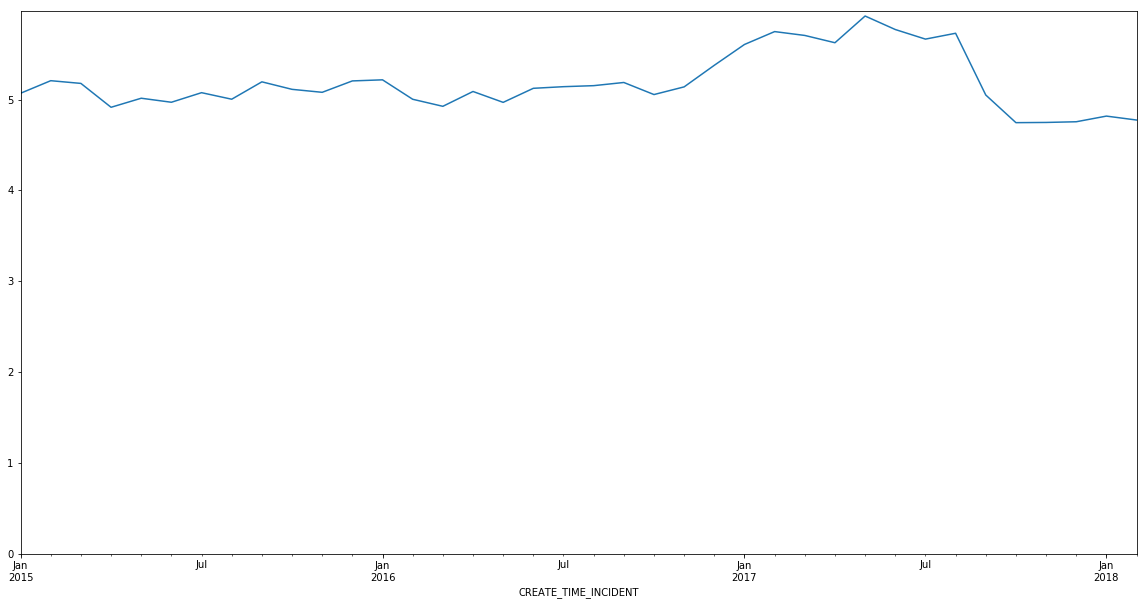

In [217]:
#A line graph showing a trend is very useful, but it the axis is not zero, it can be very misleading.
plt.figure(figsize=(20,10))
mean_monthly_TTA.plot().set_ylim(ymin=0)

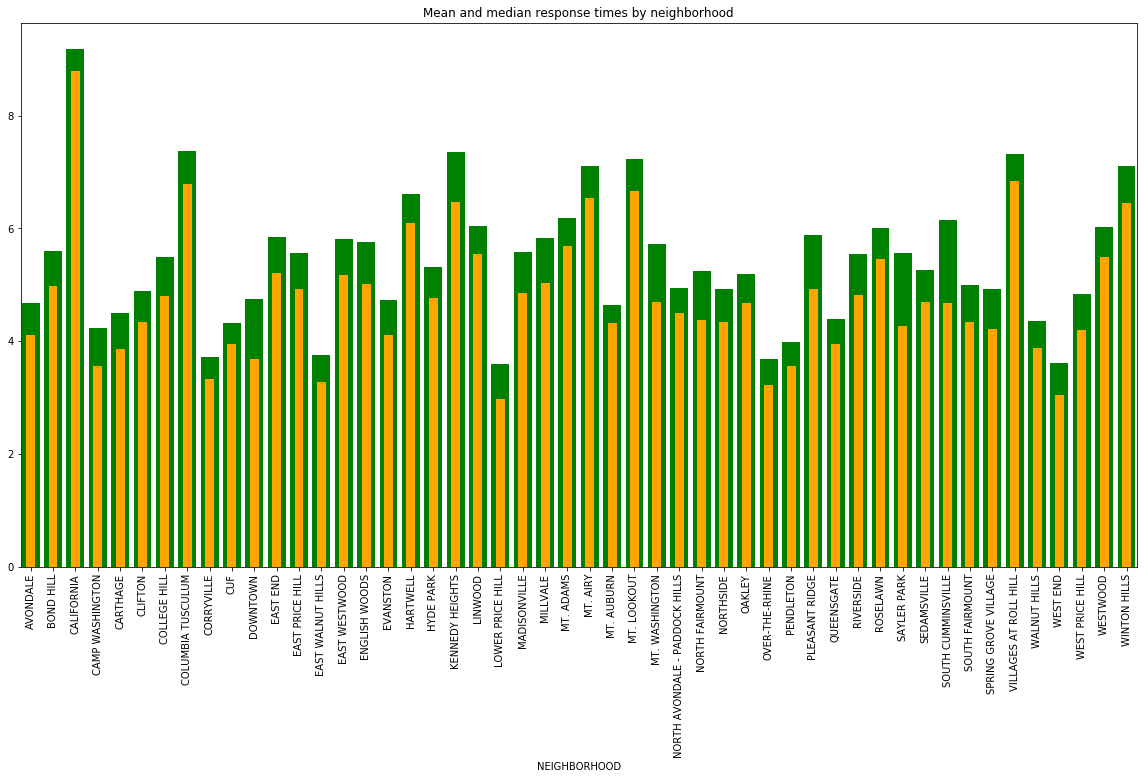

In [189]:
#Group by neighborhoods
by_neighborhood = clean_df.groupby(clean_df['NEIGHBORHOOD'])
neighborhood_means = by_neighborhood['TTA'].mean()
neighborhood_medians = by_neighborhood['TTA'].median()

plt.figure(figsize=(20,10))
plt.title('Mean and median response times by neighborhood')
neighborhood_means.plot.bar(width=0.8, color="green")
neighborhood_medians.plot.bar(width=0.4, color="orange")
plt.show()

In [131]:
neighborhood_medians.describe

<bound method NDFrame.describe of NEIGHBORHOOD
AVONDALE                          4.116667
BOND HILL                         4.983333
CALIFORNIA                        8.800000
CAMP WASHINGTON                   3.566667
CARTHAGE                          3.866667
CLIFTON                           4.333333
COLLEGE HILL                      4.800000
COLUMBIA TUSCULUM                 6.791667
CORRYVILLE                        3.333333
CUF                               3.950000
DOWNTOWN                          3.683333
EAST END                          5.200000
EAST PRICE HILL                   4.916667
EAST WALNUT HILLS                 3.283333
EAST WESTWOOD                     5.166667
ENGLISH WOODS                     5.016667
EVANSTON                          4.100000
HARTWELL                          6.100000
HYDE PARK                         4.766667
KENNEDY HEIGHTS                   6.466667
LINWOOD                           5.550000
LOWER PRICE HILL                  2.966667
MADISON

In [211]:
#What are the most common entries in the CFD_INCIDENT_TYPE_GROUP ?
inc_groups = clean_df.groupby(clean_df['CFD_INCIDENT_TYPE_GROUP'])
inc_counts = inc_groups['EVENT_NUMBER'].count()
sorted_incidents = inc_counts.sort_values(ascending=False)
sorted_incidents.head()

CFD_INCIDENT_TYPE_GROUP
SICK PERSON             23652
BREATHING PROBLEMS      18960
FALLS                   17231
AUTOMATIC FIRE ALARM    13504
PERSON DOWN             11792
Name: EVENT_NUMBER, dtype: int64

In [215]:
#What are the most common incidents near campus?
campus_inc = near_uc.groupby(near_uc['CFD_INCIDENT_TYPE_GROUP'])
campus_inc_counts = campus_inc['EVENT_NUMBER'].count()
sorted_campus_incidents = campus_inc_counts.sort_values(ascending=False)
sorted_campus_incidents.head()

CFD_INCIDENT_TYPE_GROUP
AUTOMATIC FIRE ALARM    2086
PERSON DOWN             1263
SICK PERSON             1077
MEDICAL EMERGENCY       1066
FALLS                    892
Name: EVENT_NUMBER, dtype: int64

In [ ]:
#Create a horizontal bar chart of most common incidents both on and off campus